C:\Users\flare\AppData\Local\Temp\ipykernel_10388\857926502.py:112: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.tight_layout()
C:\Users\flare\AppData\Local\Temp\ipykernel_10388\857926502.py:112: UserWarning: Glyph 20184 (\N{CJK UNIFIED IDEOGRAPH-4ED8}) missing from current font.
  plt.tight_layout()
C:\Users\flare\AppData\Local\Temp\ipykernel_10388\857926502.py:112: UserWarning: Glyph 22806 (\N{CJK UNIFIED IDEOGRAPH-5916}) missing from current font.
  plt.tight_layout()
C:\Users\flare\AppData\Local\Temp\ipykernel_10388\857926502.py:112: UserWarning: Glyph 12428 (\N{HIRAGANA LETTER RE}) missing from current font.
  plt.tight_layout()
C:\Users\flare\AppData\Local\Temp\ipykernel_10388\857926502.py:112: UserWarning: Glyph 20516 (\N{CJK UNIFIED IDEOGRAPH-5024}) missing from current font.
  plt.tight_layout()
C:\Users\flare\AppData\Local\Temp\ipykernel_10388\857926502.py:112: UserWarning: Glyph 12450 (\N{KATAKANA LETTER A}) missing from current 

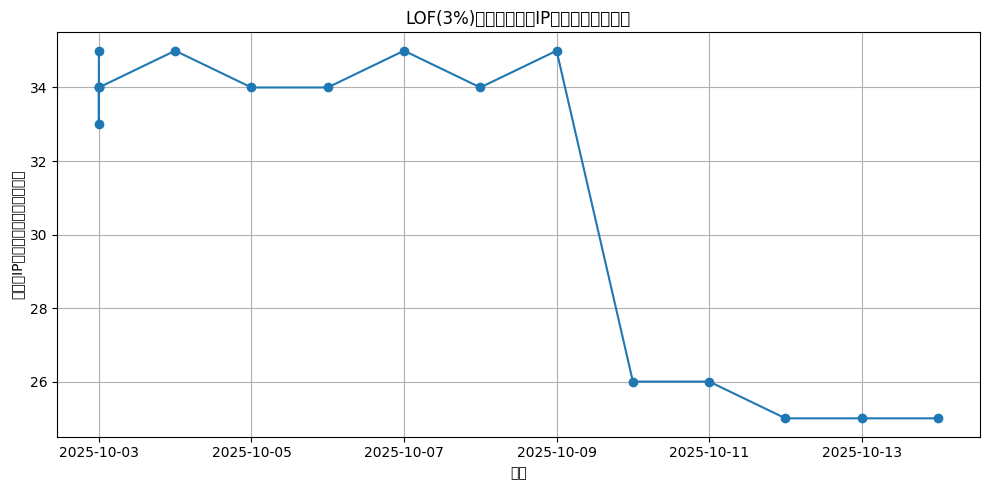

                             file       date  outlier_ip_count
0   20251003142418-TorIP_geocoded 2025-10-03                35
1   20251003143810-TorIP_geocoded 2025-10-03                33
2   20251003164852-TorIP_geocoded 2025-10-03                34
3   20251003172946-TorIP_geocoded 2025-10-03                34
4   20251003173524-TorIP_geocoded 2025-10-03                34
5   20251004173514-TorIP_geocoded 2025-10-04                35
6   20251005173523-TorIP_geocoded 2025-10-05                34
7   20251006173520-TorIP_geocoded 2025-10-06                34
8   20251007173522-TorIP_geocoded 2025-10-07                35
9   20251008173518-TorIP_geocoded 2025-10-08                34
10  20251009173527-TorIP_geocoded 2025-10-09                35
11  20251010173526-TorIP_geocoded 2025-10-10                26
12  20251011173523-TorIP_geocoded 2025-10-11                26
13  20251012173526-TorIP_geocoded 2025-10-12                25
14  20251013173525-TorIP_geocoded 2025-10-13           

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import os, zipfile, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

# ===== 設定 =====
ZIP_PATH = "./isolation_forest.zip"     # ZIPファイルパス
EXTRACT_DIR = "./isolation_forest_all"  # 展開先ディレクトリ

# ===== ZIP展開 =====
os.makedirs(EXTRACT_DIR, exist_ok=True)
with zipfile.ZipFile(ZIP_PATH, "r") as z:
    z.extractall(EXTRACT_DIR)

# ===== CSV列挙 =====
csv_files = []
for root, _, files in os.walk(EXTRACT_DIR):
    for f in files:
        if f.lower().endswith(".csv"):
            csv_files.append(os.path.join(root, f))
csv_files.sort()

# ===== 補助関数 =====
IPV4_RE = re.compile(r"\b(?:(?:25[0-5]|2[0-4]\d|1?\d?\d)\.){3}(?:25[0-5]|2[0-4]\d|1?\d?\d)\b")

def detect_lat_lon_columns(columns):
    lat = next((c for c in columns if "lat" in c.lower()), None)
    lon = next((c for c in columns if ("lon" in c.lower()) or ("lng" in c.lower()) or ("longi" in c.lower())), None)
    return lat, lon

def detect_ip_column(df):
    """列名や中身からIP列を推定"""
    lower = [c.lower() for c in df.columns]
    for p in ["ip", "ip_address", "source_ip", "src_ip", "dst_ip", "address"]:
        if p in lower:
            return df.columns[lower.index(p)]
    for c in df.columns:
        if "ip" in c.lower():
            return c
    return None

# ===== 集計結果を格納 =====
summary = []

# ===== 各CSVを処理 =====
for path in csv_files:
    try:
        df = pd.read_csv(path)
    except Exception as e:
        print(f"[SKIP] 読み込み失敗 {path}: {e}")
        continue

    lat_col, lon_col = detect_lat_lon_columns(df.columns)
    if not lat_col or not lon_col:
        continue

    # 緯度経度を数値化
    df[lat_col] = pd.to_numeric(df[lat_col], errors="coerce")
    df[lon_col] = pd.to_numeric(df[lon_col], errors="coerce")
    df = df.dropna(subset=[lat_col, lon_col])
    df = df[(df[lat_col].between(-90, 90)) & (df[lon_col].between(-180, 180))]
    if len(df) < 5:
        continue

    X = df[[lon_col, lat_col]].to_numpy()
    n_neighbors = max(10, min(35, int(len(X) * 0.03)))
    if n_neighbors >= len(X):
        n_neighbors = max(5, len(X) - 1)

    # ===== LOF 3% =====
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=0.03)
    y_pred = lof.fit_predict(X)
    is_out = (y_pred == -1)

    # ===== IP抽出 =====
    ip_col = detect_ip_column(df)
    ips = []
    if ip_col:
        ips = df.loc[is_out, ip_col].astype(str).tolist()
    else:
        text_cols = [c for c in df.columns if df[c].dtype == "object"]
        if text_cols:
            concat_text = df[text_cols].astype(str).agg(" ".join, axis=1)
            out_text = concat_text[is_out]
            for line in out_text:
                m = IPV4_RE.search(line)
                if m:
                    ips.append(m.group(0))
    uniq_ips = len(set(ips))

    # ファイル名から日付抽出
    fname = os.path.basename(path).replace(".csv", "")
    date_match = re.search(r"(\d{8})", fname)
    date = pd.to_datetime(date_match.group(1), format="%Y%m%d") if date_match else pd.NaT

    summary.append({"file": fname, "date": date, "outlier_ip_count": uniq_ips})

# ===== 集計とプロット =====
summary_df = pd.DataFrame(summary).dropna(subset=["date"]).sort_values("date")

if not summary_df.empty:
    plt.figure(figsize=(10, 5))
    plt.plot(summary_df["date"], summary_df["outlier_ip_count"], marker="o")
    plt.title("LOF(3%)による外れ値IPアドレス数の推移")
    plt.xlabel("日付")
    plt.ylabel("外れ値IPアドレス数（ユニーク）")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print(summary_df)
else:
    print("外れ値IPアドレスを検出できるデータがありません。")


[INIT] removed: cpu_metrics_2.db


ts,cpu_percent,temp_c,cpu_user_pct,cpu_system_pct,cpu_idle_pct,cpu_iowait_pct,cpu_ctx_switches,cpu_interrupts,cpu_soft_intr,cpu_syscalls,cpu_logical,cpu_physical,cpu_freq_mhz,cpu_freq_min_mhz,cpu_freq_max_mhz,per_core_cpu,per_core_freq,mem_percent,mem_total,mem_available,mem_used,mem_free,mem_cached,mem_buffers,mem_shared,swap_percent,swap_total,swap_used,swap_free,swap_sin,swap_sout,load1,load5,load15,hostname,username
2025-10-28T09:12:50.942337Z,0.0,-1,6.8,2.1,90.9,-1,414005161,381519186,0,1899639861,4,2,1209.0,0.0,1512.0,"[0.0, 0.0, 0.0, 0.0]",[1209.0],81.3,8473911296,1587052544,6886858752,1587052544,-1,-1,-1,18.3,5637144576,1031176192,4605968384,0,0,-1,-1,-1,DESKTOP-8FOAVTD,flare
2025-10-28T09:12:50.953309Z,62.5,-1,45.2,15.2,37.5,-1,414025186,381537304,0,1899747728,4,2,1209.0,0.0,1512.0,"[69.6, 56.7, 68.4, 54.7]",[1209.0],81.0,8473911296,1610706944,6863204352,1610706944,-1,-1,-1,18.3,5637144576,1031176192,4605968384,0,0,-1,-1,-1,DESKTOP-8FOAVTD,flare
2025-10-28T09:12:51.957307Z,15.